<a href="https://colab.research.google.com/github/LizzetClifton/MathApp/blob/master/SUM%2BMIT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUM+MIT CNN Model

This notebook contains the training for the model, and the corresponding predictions, with the clean datasets. You must import inverted_df and inverted_test_df

## CNN for Numbers & Symbols

In [0]:
# Import all necessary packages
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#from zipfile import ZipFile
from sklearn.datasets import load_files
import matplotlib.pyplot as plt 
import pandas as pd
import cv2
import math
import imageio
import numpy as np
import os 
from keras.preprocessing.image import img_to_array
from PIL import Image, ImageOps
import glob
import re

In [0]:
# Additional imports
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
# read in clean datasets
train_math = pd.read_csv('inverted_df.csv')
test_math = pd.read_csv('inverted_test_df.csv')

In [0]:
# Function to turn df into tensorflow dataset
def tfDataset(math_dataset):
  tf.enable_eager_execution()

  # making a new list for columns so that they can be ints
  # and the target can be a string
  new_list = list(range(784))
  new_list.append('Target')

  # Used to be train symbols
  math_dataset.columns = new_list
  features = list(range(784))
  
  # Create tf training dataset
  dataset = (
      tf.data.Dataset.from_tensor_slices(
          (
              tf.cast(math_dataset[features].values, tf.float32),
              tf.cast(math_dataset['Target'].values, tf.int32)
          )
      )
  )

  return dataset

In [0]:
# Turn train and test dataframes into tf datasets
training_dataset = tfDataset(train_math)
testing_dataset = tfDataset(test_math)

In [0]:
# Create the class names
# These are the real class names, not the ones we mapped to numbers
class_names = ['0', '1', '2', '3', '4', '5','6','7','8','9','-','+','times','div']

In [0]:
# Check number of training and testing examples
num_train_examples = len(train_math)
num_test_examples = len(test_math)

print(num_train_examples, num_test_examples)

69776 12444


In [0]:
# Function will reshape each element in the tensor
# from [784] array to [28,28,1] array
def reshape(images, labels):
  images = tf.reshape(images, (28,28,1))
  return images, labels

# The map function applies the reshaping function to each element in the train
# and test datasets
training_dataset =  training_dataset.map(reshape)
testing_dataset  =  testing_dataset.map(reshape)

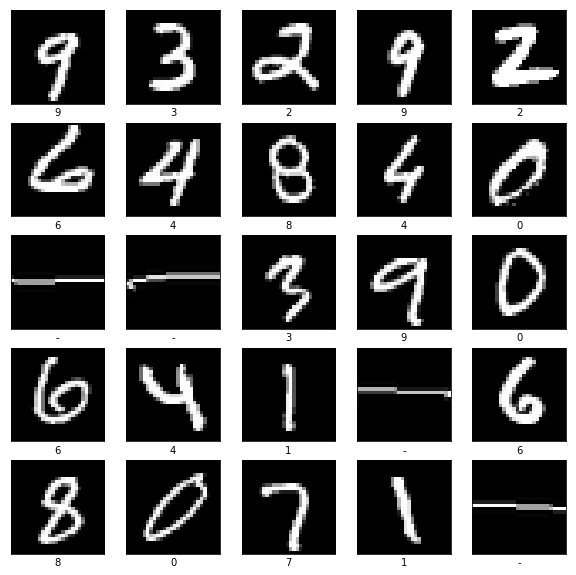

In [0]:
# We are reshaping and viewing 25 of the images from our dataset
plt.figure(figsize=(10,10))
i = 0

for (image, label) in testing_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap='gray')
    plt.xlabel(class_names[label])
    i += 1
plt.show()

### Build the Model

In [0]:
# Create the model
model = tf.keras.Sequential([
    # create first convolutional layer, with 3x3 filter and ReLu activation
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    # Perform max pooling with 2x2 matrix
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(14,  activation=tf.nn.softmax)
])

In [0]:
# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
BATCH_SIZE = 32
# Shuffle() will allocate a buffer of size of the number of training examples
# for picking random entries. Repeat() will re-initialize the dataset once all
# examples have been taken. Finally, batch() creates batches of the dataset with
# batch size given as batch_size which is also the length of the batches
train_dataset = training_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = testing_dataset.batch(BATCH_SIZE)

In [0]:
checkpoint_path = "folder_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only = True,
                                                verbose=1)

In [0]:
# Train the model
# .ceil() rounds number up to nearest integer
model.fit(train_dataset, epochs=5, 
          steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE), 
          callbacks = [cp_callback])

### Let's evaluate accuracy

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

In [0]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print('Restored model accuracy:', acc)

In [0]:
# Save the model
model.save("cnn.h5")

### Loading model

If you have already run the code up to here once in another session, then you should have saved a cnn.h5 file. If you already have that, you can skip the cells under "Build the Model" and "Let's evaluate accuracy" and run the cell below.

In [0]:
new_model = tf.keras.models.load_model('cnn.h5')
new_model.summary()
BATCH_SIZE = 32
test_dataset = testing_dataset.batch(BATCH_SIZE)
loss, acc = new_model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print('Restored model accuracy:', acc)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_3 (Dense)              (None, 14)               

## Let's make some predictions

In [0]:
# Get the first prediction
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [0]:
type(test_images)

numpy.ndarray

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [0]:
# Prediction probabilities for each target
predictions

array([[1.18980900e-07, 5.47659056e-08, 4.02555571e-07, 9.65541549e-05,
        2.07459088e-05, 1.55220987e-04, 1.05509190e-09, 1.54408661e-03,
        1.25187653e-05, 9.98170257e-01, 1.74188652e-09, 2.37416629e-08,
        1.52104676e-08, 2.06484092e-08],
       [2.80652931e-11, 5.19234744e-09, 4.96094844e-06, 9.99994636e-01,
        2.24240724e-13, 1.20088814e-07, 5.81751552e-13, 2.96760949e-09,
        1.56736579e-08, 1.28899211e-08, 1.87842566e-16, 2.03595238e-13,
        7.17412685e-10, 2.22408943e-07],
       [8.46504399e-13, 3.06895465e-09, 9.99999762e-01, 1.01522289e-07,
        4.17416761e-11, 2.07076110e-12, 4.10186858e-13, 1.40743602e-12,
        9.92712117e-08, 1.40234629e-10, 1.53924119e-15, 2.04256653e-10,
        1.20704322e-10, 4.17899937e-09],
       [2.56804753e-07, 3.77040664e-07, 1.60853119e-06, 1.12410584e-04,
        2.60701618e-05, 1.20695600e-04, 8.32255242e-09, 1.58396026e-04,
        2.56096482e-05, 9.99554574e-01, 1.27108168e-09, 4.67364529e-08,
        5.225

A prediction is an array of 14 numbers. These describe the "confidence" of the model that the image corresponds to each of the 14 different elements in the dataset (10 digits, 4 symbols). We can see which label has the highest confidence value:

In [0]:
np.argmax(predictions[0])

9

So the model is most confident that this image is a 9 or `class_names[8]`. And we can check the test label to see this is correct:

In [0]:
test_labels[0]

9

We can graph this to look at the full set of 14 class predictions

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

Let's look at the first image, predictions, and prediction array. 

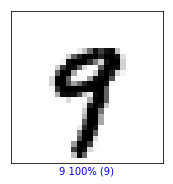

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

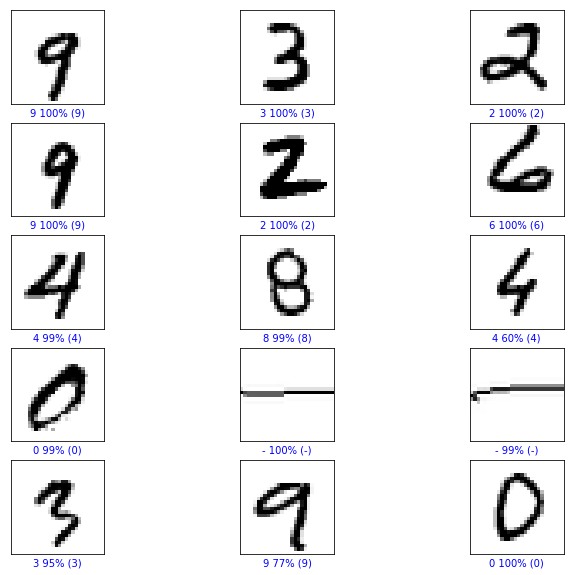

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)

You now have a trained model and you can download the .h5 model file.